In [1]:
# =========================
# Configuración de entradas
# =========================
# Rutas más probables del consolidado exportado
PREFERRED_PATHS = [
    r"C:\PROY_FINAL_ML\data\processed\cba_clean.csv",
    r"C:\PROY_FINAL_ML\data\processed\cba_clean.xlsx",
    r"C:\PROY_FINAL_ML\data\processed\cba_clean.parquet",
    "data/processed/cba_clean.csv",
    "data/processed/cba_clean.xlsx",
    "data/processed/cba_clean.parquet",
]

CANDIDATES = {
    "producto": ["producto","articulo","descripcion","producto_nombre","item","nombre_producto"],
    "presentacion": ["presentacion","presentación","medida","tamano","tamaño","unidad","presentacion_producto"],
    "supermercado": ["supermercado","establecimiento","tienda","local","sucursal","comercio"],
    "fecha_mes": ["fecha_mes","anio_mes","año_mes","periodo","mes","periodo_mes","fecha","fecha_corte"],
    "precio": ["precio","precio_venta","valor","precio_unitario","precio promedio","precio_promedio","p_venta"]
}

# Parámetros
IQR_K   = 3.0                 # sensibilidad para outliers (3 es robusto)
SAVE_DIR = "outputs/eda"      # destino de tablas y figuras


In [2]:
import os, re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

os.makedirs(SAVE_DIR, exist_ok=True)

def first_existing(paths):
    for p in paths:
        if Path(p).exists():
            return str(Path(p))
    return None

def read_any(path):
    p = str(path)
    if p.lower().endswith(".parquet"):
        return pd.read_parquet(p)
    if p.lower().endswith((".xlsx",".xls")):
        return pd.read_excel(p)  # primera hoja
    return pd.read_csv(p, sep=None, engine="python", encoding="utf-8-sig")

def map_columns(df, candidates):
    cols_lower = {c.lower(): c for c in df.columns}
    mapping = {}
    for canon, cands in candidates.items():
        found = None
        for c in cands:
            if c.lower() in cols_lower:
                found = cols_lower[c.lower()]; break
        mapping[canon] = found
    return mapping

def normalize_month(series):
    def norm_one(x):
        if pd.isna(x): return pd.NaT
        s = str(x).strip()
        if re.fullmatch(r"\d{6}", s):           # YYYYMM
            s = f"{s[:4]}-{s[4:]}-01"
        elif re.fullmatch(r"\d{4}-\d{2}", s):   # YYYY-MM
            s = f"{s}-01"
        elif re.fullmatch(r"\d{4}/\d{2}", s):   # YYYY/MM
            y,m = s.split("/"); s = f"{y}-{m}-01"
        elif re.fullmatch(r"\d{2}/\d{4}", s):   # MM/YYYY
            m,y = s.split("/"); s = f"{y}-{m}-01"
        return s
    s = series.map(norm_one)
    s = pd.to_datetime(s, errors="coerce")
    # forzamos al inicio de mes
    return s.values.astype("datetime64[M]").astype("datetime64[ns]")

def to_float(x):
    if isinstance(x, str): x = x.replace(",", ".")
    return pd.to_numeric(x, errors="coerce")

# 1) localizar archivo consolidado
src = first_existing(PREFERRED_PATHS)
if not src:
    raise SystemExit(" No encontré.")

print(f"[OK] Leyendo: {src}")
df0 = read_any(src)
print(df0.shape, list(df0.columns)[:15])

# 2) mapeo flexible => esquema canónico
mp = map_columns(df0, CANDIDATES)
print("[INFO] Mapeo detectado:", mp)

df = pd.DataFrame()
for canon in ["producto","presentacion","supermercado","fecha_mes","precio"]:
    col = mp.get(canon)
    df[canon] = df0[col] if (col in df0.columns) else np.nan

# normalizaciones
df["fecha_mes"] = normalize_month(df["fecha_mes"])
df["precio"]    = df["precio"].apply(to_float)
for c in ["producto","presentacion","supermercado"]:
    df[c] = df[c].astype(str).str.strip().str.lower()

display(df.head(5))


[OK] Leyendo: C:\PROY_FINAL_ML\data\processed\cba_clean.csv
(114444, 9) ['establecimiento', 'producto', 'anio_mes', 'medida', 'source_file', 'year', 'month', 'precio', 'periodo']
[INFO] Mapeo detectado: {'producto': 'producto', 'presentacion': 'medida', 'supermercado': 'establecimiento', 'fecha_mes': 'anio_mes', 'precio': 'precio'}


,producto,presentacion,supermercado,fecha_mes,precio
0,aceite vegetal nacional,142 litros,aba_beraka,2021-01-01,3.35
1,aceite vegetal nacional,142 litros,aba_beraka,2021-02-01,3.35
2,aceite vegetal nacional,142 litros,aba_beraka,2021-03-01,3.35
3,aceite vegetal nacional,142 litros,aba_beraka,2021-04-01,3.35
4,aceite vegetal nacional,142 litros,aba_beraka,2021-05-01,3.35


In [3]:
# ================================
#  Tratamiento de valores nulos
# ================================
import numpy as np
import pandas as pd
from collections import defaultdict

#  Parámetros 
IMPUTAR_PRECIOS       = True 
RELLENAR_PRESENTACION = True 
RELLENAR_SUPERMERCADO = False  

# --- Resumen de nulos ---
res_nulos = (df.isna().mean()*100).sort_values(ascending=False).to_frame("pct_nulos")
res_nulos.to_csv(f"{SAVE_DIR}/resumen_nulos.csv")
display(res_nulos)

# --- Presentación: normaliza y rellena ---
if RELLENAR_PRESENTACION:
    df["presentacion"] = df["presentacion"].replace(["", "nan", "None", "NaN"], np.nan)
    moda_por_prod = (
        df.groupby("producto")["presentacion"]
          .agg(lambda s: s.mode(dropna=True).iat[0] if not s.mode(dropna=True).empty else np.nan)
    )
    df["presentacion"] = df.apply(
        lambda r: r["presentacion"] if pd.notna(r["presentacion"]) else moda_por_prod.get(r["producto"], np.nan),
        axis=1
    ).fillna("na")

if RELLENAR_SUPERMERCADO:
    df["supermercado"] = df["supermercado"].fillna("desconocido")
else:
    df = df[~df["supermercado"].isna()].copy()

df = df[~df["fecha_mes"].isna()].copy()

if IMPUTAR_PRECIOS:
    df["precio_original"] = df["precio"]
    g0 = df.groupby(["producto","presentacion","supermercado","fecha_mes"])["precio"].transform("median")
    g1 = df.groupby(["producto","presentacion","supermercado"])["precio"].transform("median")
    g2 = df.groupby(["producto","supermercado"])["precio"].transform("median")
    g3 = df.groupby(["producto"])["precio"].transform("median")
    g4 = df["precio"].median()

    df["precio"] = df["precio"].fillna(g0).fillna(g1).fillna(g2).fillna(g3).fillna(g4)
    df["precio_imputado"] = df["precio_original"].isna()

    # Log de imputaciones
    df.loc[df["precio_imputado"], 
           ["producto","presentacion","supermercado","fecha_mes","precio_original","precio"]
    ].to_csv(f"{SAVE_DIR}/imputaciones_precio.csv", index=False)

    print(f"[INFO] Precios imputados: {int(df['precio_imputado'].sum())}")
else:
    antes = len(df)
    df = df.dropna(subset=["precio"]).copy()
    print(f"[INFO] Filas eliminadas por precio nulo: {antes - len(df)}")

print("[OK].")


,pct_nulos
producto,0.0
presentacion,0.0
supermercado,0.0
fecha_mes,0.0
precio,0.0


[INFO] Precios imputados: 0
[OK].


In [4]:
schema = pd.DataFrame({
    "columna": df.columns,
    "dtype": [str(df[c].dtype) for c in df.columns],
    "n_nulos": [df[c].isna().sum() for c in df.columns],
    "pct_nulos": [df[c].isna().mean()*100 for c in df.columns]
})
schema.to_csv(f"{SAVE_DIR}/schema_validacion.csv", index=False)
display(schema)

print("\n[CHECK] Rango precio:")
display(df["precio"].describe())

# Precios fuera de rango (regla amplia para detectar errores obvios)
df["precio_out_of_range"] = (df["precio"]<=0) | (df["precio"]>1000)
df.loc[df["precio_out_of_range"]].to_csv(f"{SAVE_DIR}/precios_fuera_de_rango.csv", index=False)
print(f"[INFO] Fuera de rango: {int(df['precio_out_of_range'].sum())} filas (exportadas si > 0).")

# Duplicados por clave mínima
KEY = ["producto","presentacion","supermercado","fecha_mes"]
dups = df[df.duplicated(KEY, keep=False)].sort_values(KEY)
dups.to_csv(f"{SAVE_DIR}/duplicados_por_clave.csv", index=False)
print(f"[INFO] Duplicados por {KEY}: {dups.shape[0]} filas (exportadas).")


,columna,dtype,n_nulos,pct_nulos
0,producto,object,0,0.0
1,presentacion,object,0,0.0
2,supermercado,object,0,0.0
3,fecha_mes,datetime64[ns],0,0.0
4,precio,float64,0,0.0
5,precio_original,float64,0,0.0
6,precio_imputado,bool,0,0.0



[CHECK] Rango precio:


count    114444.000000
mean          2.458949
std           2.195456
min           0.160000
25%           0.880000
50%           1.713333
75%           3.200000
max          16.300000
Name: precio, dtype: float64

[INFO] Fuera de rango: 0 filas (exportadas si > 0).
[INFO] Duplicados por ['producto', 'presentacion', 'supermercado', 'fecha_mes']: 0 filas (exportadas).


In [5]:
import numpy as np
import pandas as pd

IQR_K = globals().get("IQR_K", 3.0)
SAVE_DIR = globals().get("SAVE_DIR", "outputs/eda")
group_cols = ["producto","presentacion","supermercado"]

df_valid = df.dropna(subset=["precio","fecha_mes"]).copy()
if df_valid.empty:
    raise SystemExit("❌ No hay datos válidos (precio/fecha) para outliers.")

g = (df_valid
     .groupby(group_cols)["precio"]
     .agg(q1=lambda s: s.quantile(0.25),
          q3=lambda s: s.quantile(0.75),
          vmin="min", vmax="max", n="count")
     .reset_index())
g["iqr"] = g["q3"] - g["q1"]
g["lo"]  = np.where(g["n"]>=4, g["q1"] - IQR_K*g["iqr"], np.nan)
g["hi"]  = np.where(g["n"]>=4, g["q3"] + IQR_K*g["iqr"], np.nan)
mask0 = g["iqr"].fillna(0) == 0
g.loc[mask0, "lo"] = g.loc[mask0, "vmin"] - 1e-9
g.loc[mask0, "hi"] = g.loc[mask0, "vmax"] + 1e-9
bounds_gp = g[group_cols + ["lo","hi"]]

# 2) Fallback por PRODUCTO
p = (df_valid
     .groupby(["producto"])["precio"]
     .agg(q1=lambda s: s.quantile(0.25),
          q3=lambda s: s.quantile(0.75),
          vmin="min", vmax="max", n="count")
     .reset_index())
p["iqr"] = p["q3"] - p["q1"]
p["lo_prod"] = np.where(p["n"]>=4, p["q1"] - IQR_K*p["iqr"], np.nan)
p["hi_prod"] = np.where(p["n"]>=4, p["q3"] + IQR_K*p["iqr"], np.nan)
mask0p = p["iqr"].fillna(0) == 0
p.loc[mask0p, "lo_prod"] = p.loc[mask0p, "vmin"] - 1e-9
p.loc[mask0p, "hi_prod"] = p.loc[mask0p, "vmax"] + 1e-9
prod_bounds = p[["producto","lo_prod","hi_prod"]]

# 3) Fallback GLOBAL
q1_g = df_valid["precio"].quantile(0.25)
q3_g = df_valid["precio"].quantile(0.75)
iqr_g = q3_g - q1_g
if pd.isna(iqr_g) or iqr_g == 0:
    glob_lo = df_valid["precio"].min() - 1e-9
    glob_hi = df_valid["precio"].max() + 1e-9
else:
    glob_lo = q1_g - IQR_K*iqr_g
    glob_hi = q3_g + IQR_K*iqr_g

# 4) Aplicar límites
df_b = (df_valid
        .merge(bounds_gp, on=group_cols, how="left")
        .merge(prod_bounds, on="producto", how="left"))

df_b["lo_final"] = df_b["lo"].fillna(df_b["lo_prod"]).fillna(glob_lo)
df_b["hi_final"] = df_b["hi"].fillna(df_b["hi_prod"]).fillna(glob_hi)

mask_out = (df_b["precio"] < df_b["lo_final"]) | (df_b["precio"] > df_b["hi_final"])
outliers = df_b.loc[mask_out].copy()
clean    = df_b.loc[~mask_out].drop(columns=["lo","hi","lo_prod","hi_prod","lo_final","hi_final"], errors="ignore")

# 5) Guardar
import os
os.makedirs(SAVE_DIR, exist_ok=True)
outliers.to_csv(f"{SAVE_DIR}/outliers_IQR.csv", index=False)
clean.to_csv(f"{SAVE_DIR}/clean_IQR.csv", index=False)

print(f"[INFO] Outliers detectados (k={IQR_K}): {len(outliers)}")
print(f"[INFO] Filas limpias: {len(clean)}  |  Grupos: {bounds_gp.shape[0]}")
display(outliers.head(10))


[INFO] Outliers detectados (k=3.0): 1409
[INFO] Filas limpias: 113035  |  Grupos: 6358


,producto,presentacion,supermercado,fecha_mes,precio,precio_original,precio_imputado,precio_out_of_range,lo,hi,lo_prod,hi_prod,lo_final,hi_final
647,codito,454 gramos,aba_el_cangrejo_bella_vista,2022-06-01,0.600,0.600,False,False,0.75625,1.150000,0.350000,1.330000,0.75625,1.150000
789,macarrones espaguetti cal 3- 5,454 gramos,aba_el_cangrejo_bella_vista,2022-04-01,0.600,0.600,False,False,0.86250,1.103125,-0.030000,1.510000,0.86250,1.103125
790,macarrones espaguetti cal 3- 5,454 gramos,aba_el_cangrejo_bella_vista,2022-05-01,0.600,0.600,False,False,0.86250,1.103125,-0.030000,1.510000,0.86250,1.103125
791,macarrones espaguetti cal 3- 5,454 gramos,aba_el_cangrejo_bella_vista,2022-06-01,0.600,0.600,False,False,0.86250,1.103125,-0.030000,1.510000,0.86250,1.103125
825,margarina en barra,1 kilogramos,aba_el_cangrejo_bella_vista,2022-04-01,4.410,4.410,False,False,3.92000,4.007500,-0.990000,8.460000,3.92000,4.007500
826,margarina en barra,1 kilogramos,aba_el_cangrejo_bella_vista,2022-05-01,5.070,5.070,False,False,3.92000,4.007500,-0.990000,8.460000,3.92000,4.007500
827,margarina en barra,1 kilogramos,aba_el_cangrejo_bella_vista,2022-06-01,5.730,5.730,False,False,3.92000,4.007500,-0.990000,8.460000,3.92000,4.007500
892,pl tano verde,1 unidades,aba_el_cangrejo_bella_vista,2021-11-01,0.250,0.250,False,False,0.27500,0.406250,-0.083482,0.694643,0.27500,0.406250
915,porotos rojos,1 kilogramos,aba_el_cangrejo_bella_vista,2022-04-01,3.090,3.090,False,False,3.32375,3.548333,1.160000,4.730000,3.32375,3.548333
916,porotos rojos,1 kilogramos,aba_el_cangrejo_bella_vista,2022-05-01,3.255,3.255,False,False,3.32375,3.548333,1.160000,4.730000,3.32375,3.548333


In [6]:
# Etiqueta qué nivel de límite se usó (grupo / producto / global)
import pandas as pd
def _nivel(row):
    if pd.notna(row.get("lo")) and pd.notna(row.get("hi")) and \
       row["lo_final"] == row["lo"] and row["hi_final"] == row["hi"]:
        return "grupo"
    if pd.notna(row.get("lo_prod")) and pd.notna(row.get("hi_prod")) and \
       row["lo_final"] == row["lo_prod"] and row["hi_final"] == row["hi_prod"]:
        return "producto"
    return "global"

df_b["limite_usado"] = df_b.apply(_nivel, axis=1)

# Resumen de outliers por producto/supermercado
res_out = (outliers.groupby(["producto","supermercado"])
           .agg(outliers=("precio","size"),
                mediana=("precio","median"),
                q1=("precio", lambda s: s.quantile(0.25)),
                q3=("precio", lambda s: s.quantile(0.75)))
           .reset_index()
           .sort_values("outliers", ascending=False))
res_out.to_csv(f"{SAVE_DIR}/resumen_outliers_por_producto_super.csv", index=False)

# % de outliers vs total
porc_out = len(outliers) / (len(outliers) + len(clean)) * 100
print(f"[INFO] % outliers: {porc_out:.2f}%")
display(res_out.head(15))

# Guarda dataset enriquecido para trazabilidad
df_b.to_csv(f"{SAVE_DIR}/bounds_y_limite_usado.csv", index=False)


[INFO] % outliers: 1.23%


,producto,supermercado,outliers,mediana,q1,q3
262,lechuga,super_99_va_porras,8,3.006667,2.662500,3.655000
190,leche en polvo entera instant nea,xtra_pan_de_azécar,8,3.023333,2.630000,3.310000
54,caf molido tradicional,riba_smith_bella_vista,7,3.940000,3.511667,3.970000
578,sopa deshidratada pollo y fideos,xtra_las_acacias,7,0.380000,0.365000,0.460000
181,jugo de naranja,super_99_los_andes,7,1.196667,1.170000,1.290000
580,sopa deshidratada pollo y fideos,xtra_pan_de_azécar,7,0.410000,0.325000,0.462500
42,bistec de cinta,xtra_chepo,6,5.150000,5.150000,5.405000
475,queso blanco prensado bajo en sal,rey_calle_50,6,11.900000,7.655000,14.990000
468,pulpa negra,xtra_los_pueblos,6,7.626667,6.930000,7.643333
473,queso blanco prensado bajo en sal,el_fuerte_san_miguelito,6,14.330000,11.780000,14.330000


In [7]:
def stats(df_in, by):
    g = (df_in.groupby(by)["precio"]
         .agg(n="count", media="mean", mediana="median", std="std", minimo="min", maximo="max")
         .reset_index())
    g["cv_%"] = (g["std"] / g["media"] * 100).round(2)
    return g

stats_prod = stats(clean, ["producto"])
stats_sup  = stats(clean, ["supermercado"])

stats_prod.to_csv(f"{SAVE_DIR}/stats_por_producto.csv", index=False)
stats_sup.to_csv(f"{SAVE_DIR}/stats_por_supermercado.csv", index=False)

print("[OK] Estadísticos exportados.")
display(stats_prod.sort_values("cv_%", ascending=False).head(10))
display(stats_sup.sort_values("cv_%", ascending=False).head(10))


[OK] Estadísticos exportados.


,producto,n,media,mediana,std,minimo,maximo,cv_%
48,salchichas nac empacadas tipo frankfurter,1861,5.613962,5.600000,1.957544,2.65,8.49,34.87
24,lentejas,2533,1.954753,1.870000,0.595076,0.93,4.08,30.44
57,yuca,1031,0.801654,0.724000,0.241208,0.56,1.65,30.09
2,ajo,1178,3.115739,2.938333,0.853320,1.15,4.85,27.39
35,pasta de tomate,2586,0.588652,0.650000,0.159098,0.26,0.85,27.03
49,salsa de tomate,2574,0.582937,0.650000,0.155670,0.23,0.99,26.70
50,sardina en salsa de tomate sin picante,2524,0.666364,0.690000,0.174626,0.32,1.15,26.21
47,sal,2579,0.748292,0.770000,0.189656,0.37,1.10,25.35
13,crema de maz,1286,0.707815,0.650000,0.174028,0.41,1.25,24.59
16,hojuelas de maz corn flakes cajeta,1648,2.453284,2.440000,0.599127,1.25,4.45,24.42


,supermercado,n,media,mediana,std,minimo,maximo,cv_%
112,rey_via_espaa,738,2.389024,1.520000,2.429562,0.250,11.69,101.70
115,riba_smith_transistmica,1050,3.343919,2.440000,3.387553,0.240,15.48,101.30
114,riba_smith_bella_vista,1042,3.368591,2.350000,3.410592,0.320,15.48,101.25
3,aba_los_amigos,234,1.280000,0.850000,1.267878,0.350,5.50,99.05
6,abt__la_pagoda,936,2.472361,1.720000,2.410163,0.250,14.89,97.48
138,xtra_las_acacias,1000,2.600295,1.815000,2.532781,0.205,14.74,97.40
140,xtra_market__villa_lucre,989,2.705536,1.796667,2.632715,0.225,14.74,97.31
104,rey_bombero_santa_ana,864,2.760648,1.765000,2.683655,0.480,16.30,97.21
23,casacarne_via_porras,810,2.894667,1.760000,2.807338,0.420,14.60,96.98
14,abt_la_pagoda_no_2,975,2.602932,1.720000,2.512242,0.250,14.89,96.52


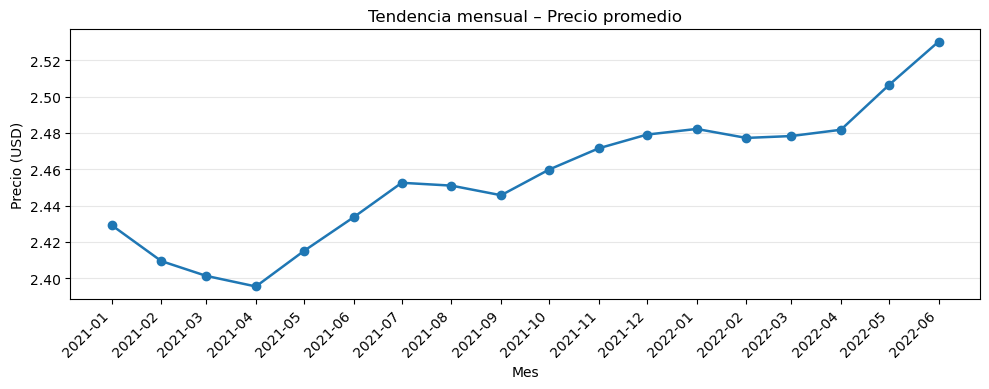

In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from pathlib import Path

# usa el dataset limpio o  df
base_df = clean if 'clean' in globals() else df
Path(SAVE_DIR).mkdir(parents=True, exist_ok=True)

# -------------------------------------------------
# 1) Tendencia mensual – Precio promedio 
# -------------------------------------------------
trend = (base_df.groupby('fecha_mes', dropna=True)['precio']
         .mean().reset_index().sort_values('fecha_mes'))

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(trend['fecha_mes'], trend['precio'], marker='o', linewidth=1.8)
ax.set_title("Tendencia mensual – Precio promedio")
ax.set_xlabel("Mes"); ax.set_ylabel("Precio (USD)")

# ticks mensuales y formato AAAA-MM
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
fig.autofmt_xdate(rotation=45, ha="right")

ax.grid(True, axis='y', alpha=0.3)
fig.tight_layout()
plt.savefig(f"{SAVE_DIR}/trend_mensual.png", dpi=144, bbox_inches="tight")
plt.show()



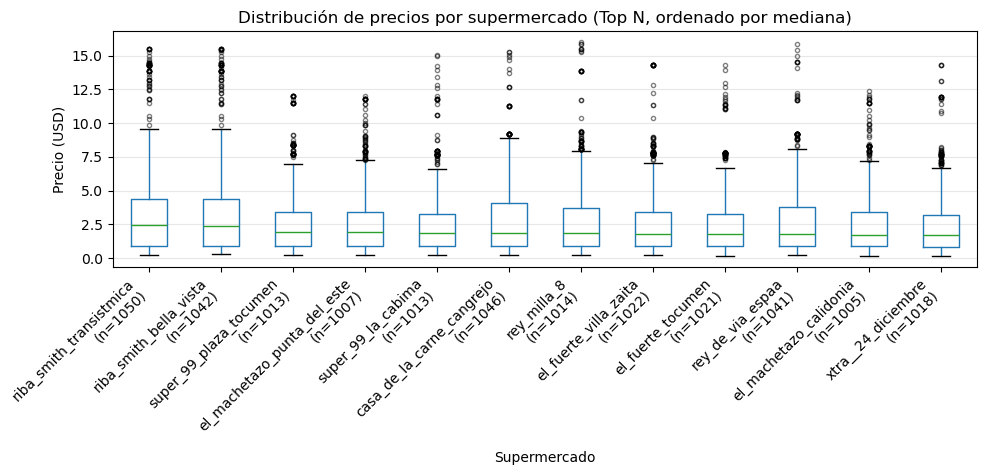

In [9]:
import matplotlib.pyplot as plt

N = 12
top_sup = clean["supermercado"].value_counts().head(N).index
sub = clean[clean["supermercado"].isin(top_sup)].copy()

# ordenar por mediana descendente
order = (sub.groupby("supermercado")["precio"]
           .median().sort_values(ascending=False).index)
sub["supermercado"] = pd.Categorical(sub["supermercado"], categories=order, ordered=True)

fig, ax = plt.subplots(figsize=(10,5))
sub.boxplot(
    column="precio", by="supermercado", ax=ax, grid=False, showfliers=True,
    flierprops=dict(marker="o", markersize=3, alpha=0.5)
)
ax.figure.suptitle("")
ax.set_title("Distribución de precios por supermercado (Top N, ordenado por mediana)")
ax.set_xlabel("Supermercado"); ax.set_ylabel("Precio (USD)")
ax.grid(axis="y", alpha=0.3)

counts = sub["supermercado"].value_counts()
ax.set_xticklabels([f"{s}\n(n={counts[s]})" for s in order], rotation=45, ha="right")

fig.tight_layout()
plt.show()


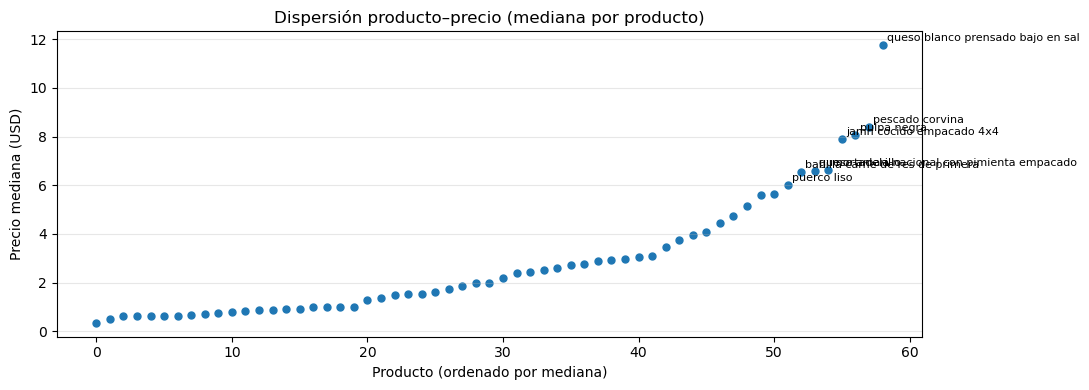

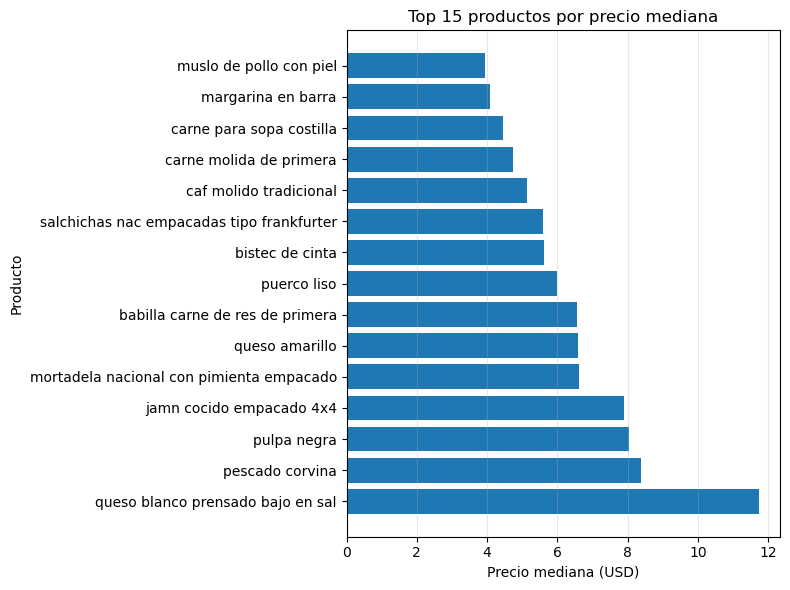

In [10]:
agg = (clean.groupby("producto")["precio"]
       .median().reset_index().sort_values("precio").reset_index(drop=True))

fig, ax = plt.subplots(figsize=(11,4))
ax.scatter(agg.index, agg["precio"], s=25)
ax.set_title("Dispersión producto–precio (mediana por producto)")
ax.set_xlabel("Producto (ordenado por mediana)"); ax.set_ylabel("Precio mediana (USD)")
ax.grid(axis="y", alpha=0.3)

# anota los 8 más caros
topk = agg.tail(8)
for i, r in topk.iterrows():
    ax.annotate(r["producto"], (i, r["precio"]),
                xytext=(3,3), textcoords="offset points", fontsize=8)
plt.tight_layout(); plt.show()

# Top 15 en barras horizontales
top15 = agg.tail(15)
fig, ax = plt.subplots(figsize=(8,6))
ax.barh(top15["producto"], top15["precio"])
ax.set_title("Top 15 productos por precio mediana")
ax.set_xlabel("Precio mediana (USD)"); ax.set_ylabel("Producto")
ax.grid(axis="x", alpha=0.3)
ax.invert_yaxis()  # el más caro arriba
plt.tight_layout(); plt.show()


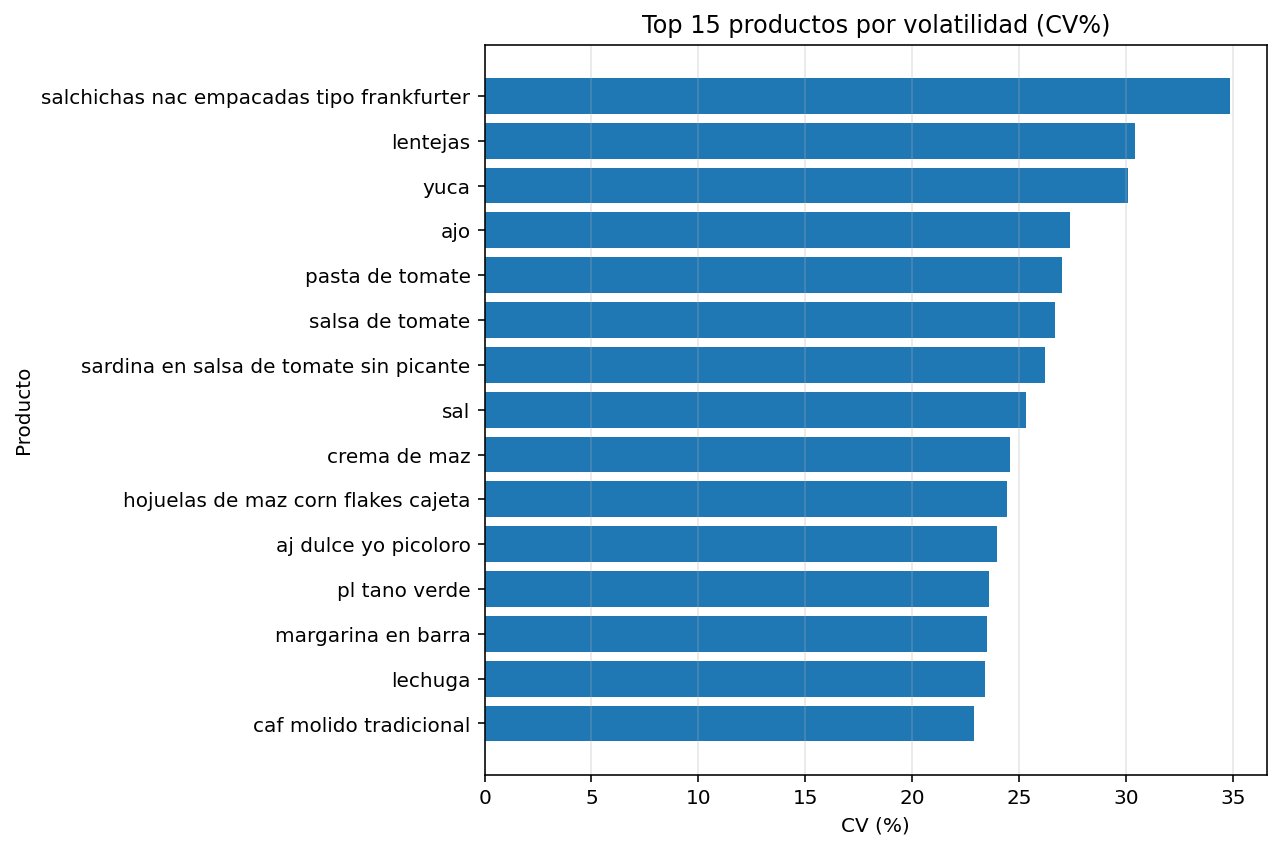

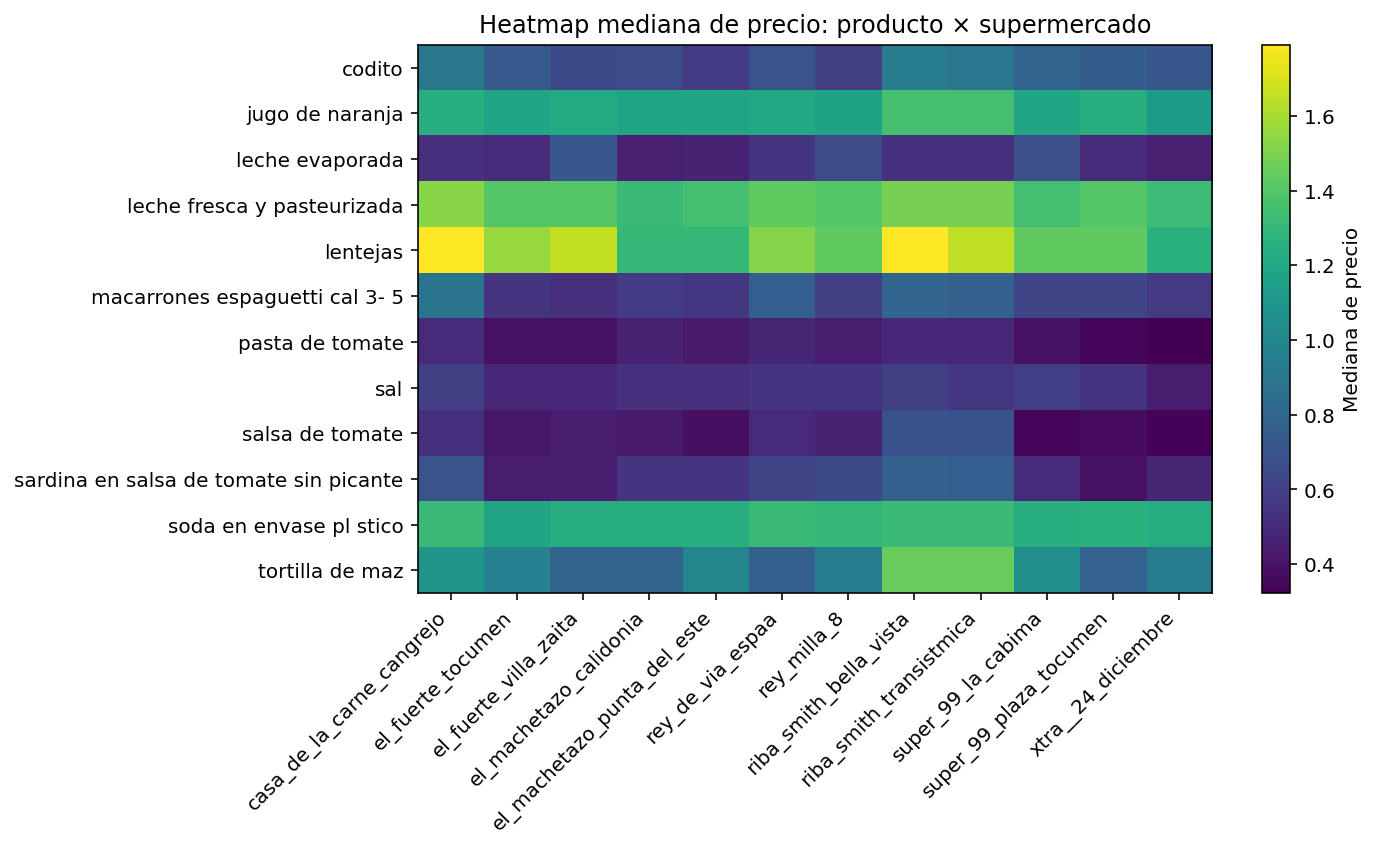

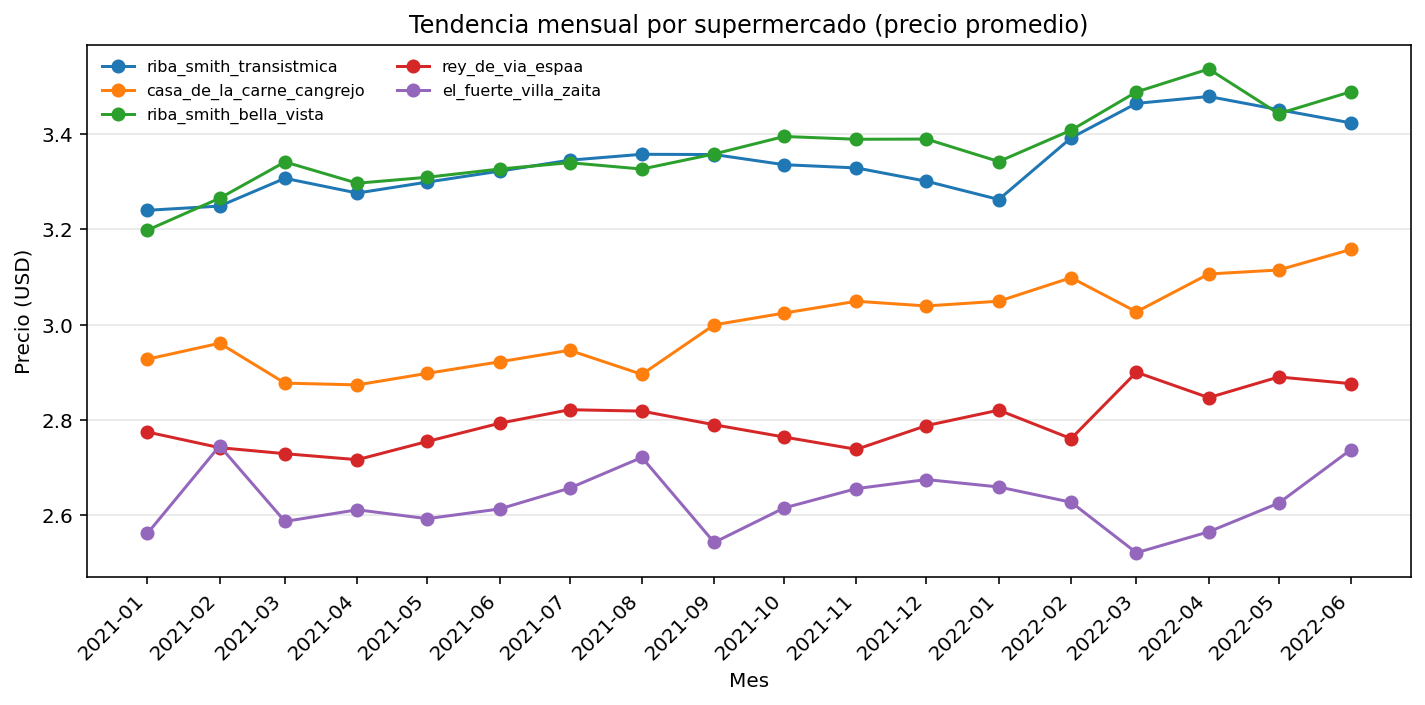

In [11]:
# === GRÁFICAS DE EDA ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path

# usa el dataset limpio si está disponible
base_df = clean if 'clean' in globals() else df.dropna(subset=['precio','fecha_mes']).copy()
Path(SAVE_DIR).mkdir(parents=True, exist_ok=True)
plt.rcParams.update({"figure.dpi": 144})

# -----------------------------------------------------------------
# 3) Top productos por volatilidad (CV%) 
# -----------------------------------------------------------------
stats_prod = (base_df.groupby('producto')['precio']
              .agg(media='mean', std='std', n='count').reset_index())
stats_prod['cv_%'] = (stats_prod['std'] / stats_prod['media'] * 100)
topk = (stats_prod[stats_prod['n']>=5]  # exige al menos 5 observaciones
        .sort_values('cv_%', ascending=False).head(15))

fig, ax = plt.subplots(figsize=(9,6))
ax.barh(topk['producto'], topk['cv_%'])
ax.set_title("Top 15 productos por volatilidad (CV%)")
ax.set_xlabel("CV (%)"); ax.set_ylabel("Producto")
ax.grid(axis='x', alpha=0.3)
ax.invert_yaxis()
fig.tight_layout()
plt.savefig(f"{SAVE_DIR}/top_productos_volatilidad_cv.png", bbox_inches="tight")
plt.show()

# --------------------------------------------------------------------------------
# 5) Heatmap producto × supermercado (precio mediana) — Top N×M para legibilidad
# --------------------------------------------------------------------------------
N_PROD, M_SUP = 12, 12
top_prods = base_df['producto'].value_counts().head(N_PROD).index
top_sups  = base_df['supermercado'].value_counts().head(M_SUP).index
hm = (base_df[base_df['producto'].isin(top_prods) & base_df['supermercado'].isin(top_sups)]
      .pivot_table(index='producto', columns='supermercado', values='precio', aggfunc='median'))

fig, ax = plt.subplots(figsize=(10,6))
im = ax.imshow(hm.values, aspect='auto')
ax.set_title("Heatmap mediana de precio: producto × supermercado")
ax.set_yticks(range(len(hm.index)));  ax.set_yticklabels(hm.index)
ax.set_xticks(range(len(hm.columns))); ax.set_xticklabels(hm.columns, rotation=45, ha='right')
fig.colorbar(im, ax=ax, label='Mediana de precio')
fig.tight_layout()
plt.savefig(f"{SAVE_DIR}/heatmap_producto_super_mediana.png", bbox_inches="tight")
plt.show()

# ------------------------------------------------------------------------------------
# 6) Tendencias por supermercado (Top 6) — líneas en una sola figura
# ------------------------------------------------------------------------------------
top6 = base_df['supermercado'].value_counts().head(5).index
tmp = (base_df[base_df['supermercado'].isin(top6)]
       .groupby(['fecha_mes','supermercado'])['precio'].mean().reset_index())
fig, ax = plt.subplots(figsize=(10,5))
for s in top6:
    t = tmp[tmp['supermercado']==s].sort_values('fecha_mes')
    ax.plot(t['fecha_mes'], t['precio'], marker='o', label=s)
ax.set_title("Tendencia mensual por supermercado (precio promedio)")
ax.set_xlabel("Mes"); ax.set_ylabel("Precio (USD)")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
fig.autofmt_xdate(rotation=45, ha="right")
ax.legend(ncol=2, fontsize=8, frameon=False)
ax.grid(axis='y', alpha=0.3)
fig.tight_layout()
plt.savefig(f"{SAVE_DIR}/tendencias_por_supermercado.png", bbox_inches="tight")
plt.show()


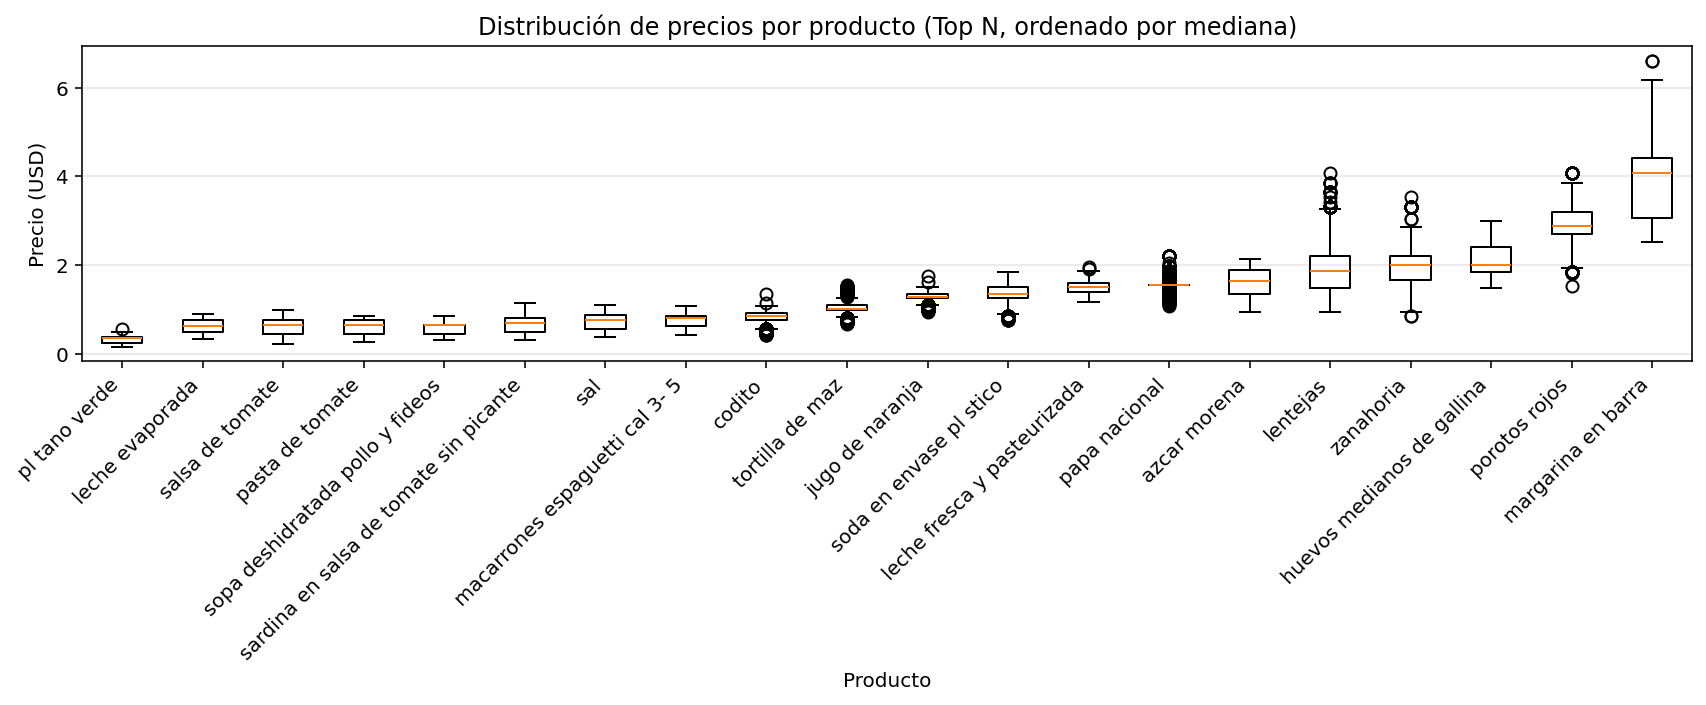

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
 
base_df = clean if 'clean' in globals() else df.dropna(subset=['precio','producto']).copy()
SAVE_DIR = globals().get("SAVE_DIR", "outputs/eda")
Path(SAVE_DIR).mkdir(parents=True, exist_ok=True)
 
N = 20  
top_prods = (base_df['producto']
             .value_counts()
             .head(N)
             .index)
 
sub = base_df[base_df['producto'].isin(top_prods)].copy()
 
# --- Orden por mediana de precio (de menor a mayor) ---
order = (sub.groupby('producto')['precio']
           .median()
           .sort_values()
           .index)
 
# --- Datos para el boxplot en el orden elegido ---
data = [sub.loc[sub['producto'] == p, 'precio'].values for p in order]
 
# --- Figura ---
fig_w = max(10, N * 0.6) 
fig, ax = plt.subplots(figsize=(fig_w, 5))
ax.boxplot(data, positions=range(len(order)), showfliers=True)
 
ax.set_title("Distribución de precios por producto (Top N, ordenado por mediana)")
ax.set_xlabel("Producto")
ax.set_ylabel("Precio (USD)")
ax.set_xticks(range(len(order)))
ax.set_xticklabels(order, rotation=45, ha="right")
ax.grid(axis="y", alpha=0.3)
 
plt.tight_layout()
plt.savefig(f"{SAVE_DIR}/boxplot_por_producto.png", dpi=144, bbox_inches="tight")
plt.show()